In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import cdist

In [2]:
def KS_power(mu, sigma, n, m, alpha=0.05, its=200):
    rejections = 0
    for i in range(its):
        A = np.random.normal(mu, sigma, size=(n,n))
        B = np.random.normal(mu, sigma, size=(m,m))

        X = np.mean(A, axis=0)
        Y = np.mean(B, axis=1)
        
        T, p = ks_2samp(X, Y)
        if p < alpha:
            rejections+=1
    return rejections / its

def MMD_power(mu, sigma, n, m, bw, b, alpha=0.05, its=200):
    rejections = 0
    for i in range(its):
        Ts = generate_null(mu, sigma, n, m, bw, b)
        
        A = np.random.normal(mu, sigma, size=(n,n))
        B = np.random.normal(mu, sigma, size=(m,m))

        X = np.mean(A, axis=0)
        Y = np.mean(B, axis=1)
        
        T = mmd(X, Y, bw)
        
        size = int(alpha*b)
        
        if T > Ts[b - size]:
            rejections += 1
            
    return rejections / its

def MMD_experiment(mc_its, mu, sigma, n, m, bw, b, alpha, its):
    power_ = np.zeros(mc_its)
    for i in range(mc_its):
        power_[i] = MMD_power(mu, sigma, n, m, bw, b, alpha, its)
    return np.mean(power_), np.std(power_, ddof=1) / np.sqrt(mc_its) 

def experiment(func, mc_its, mu, sigma, n, m, alpha, its):
    power_ = np.zeros(mc_its)
    for i in range(mc_its):
        power_[i] = func(mu, sigma, n, m, alpha, its)
    return np.mean(power_), np.std(power_, ddof=1) / np.sqrt(mc_its) 

def mmd(X, Y, bw):
    n = len(X)
    m = len(Y)
    
    Kx = np.exp(-(cdist(X[:, np.newaxis], Y[:, np.newaxis])**2) / bw)
    Ux = np.sum(Kx) / (n*(n-1))
    
    Ky = np.exp((-cdist(Y[:, np.newaxis], X[:, np.newaxis])**2) / bw)
    Uy = np.sum(Ky) / (m*(m-1))
    
    Kxy = np.exp(-(cdist(X[:, np.newaxis], Y[:, np.newaxis])**2) / bw)
    Uxy = np.sum(Kxy) / (n*m)
    
    return Ux - 2*Uxy + Uy

def generate_null(mu, sigma, n, m, bw, b):
    Ts = np.zeros(b)
    for i in range(b):
        A = np.random.normal(mu, sigma, size=(n,n))
        B = np.random.normal(mu, sigma, size=(m,m))

        X = np.mean(A, axis=0)
        Y = np.mean(B, axis=1)
        
        Ts[i] = mmd(X, Y, bw)
    return np.sort(Ts)

In [23]:
h = 0.1
hn = 100
deltas = np.arange(0.1, 1+h, step=h)
ns = np.arange(100, 700+hn, step=hn)

power_its=25
alpha=0.05
mc_its=25

power_means = np.zeros((len(ns), len(deltas)))
power_stderrs = np.zeros((len(ns), len(deltas)))

for i, n in enumerate(tqdm(ns)):
    for j, delta in enumerate(deltas):
        m=int(delta*n)
        power_means[i, j], power_stderrs[i, j] = experiment(mc_its, mu, sigma, n, m, alpha, power_its)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:10<01:38, 10.90s/it]

 20%|██        | 2/10 [00:47<02:28, 18.59s/it]

 30%|███       | 3/10 [02:06<04:17, 36.74s/it]

 40%|████      | 4/10 [04:24<06:43, 67.21s/it]

 50%|█████     | 5/10 [07:48<09:00, 108.10s/it]

 60%|██████    | 6/10 [12:59<11:16, 169.14s/it]

 70%|███████   | 7/10 [20:01<12:14, 244.82s/it]

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (7,)

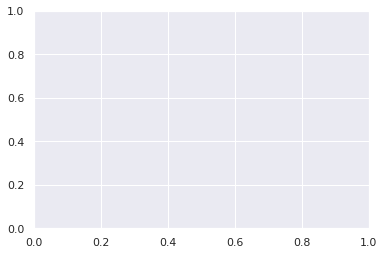

In [76]:
sns.set()
colors = sns.color_palette("Set1", n_colors = len(deltas))
fig, ax = plt.subplots(1,1)

for i, delta in enumerate(deltas):
    ax.plot(ns[:-3], power_means[:-3, i], label="m = %1.1f n"%(delta), c=colors[i])
    ax.fill_between(ns[:-3], 
            power_means[:-3,i] + 1.96*power_stderrs[:-3, i]/np.sqrt(mc_its), 
            power_means[:-3,i] - 1.96*power_stderrs[:-3, i]/np.sqrt(mc_its), 
            where=power_means[:-3, i] + 1.96*power_stderrs[:-3, i]/np.sqrt(mc_its) >= power_means[:-3, i] - 1.96*power_stderrs[:-3, i]/np.sqrt(mc_its), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('Average power')

ax.set_title('mu_X = mu_Y = 0; sigma_X = sigma_Y = 1')
# plt.savefig('power_plots.pdf')

In [8]:
h = 0.3
hn = 150
deltas = np.arange(0.1, 1+h, step=h)
ns = np.arange(100, 700+hn, step=hn)

bw = 0.1
b = 100

power_its=10
alpha=0.05
mc_its=10

mmd_power_means = np.zeros((len(ns), len(deltas)))
mmd_power_stderrs = np.zeros((len(ns), len(deltas)))

for i, n in enumerate(tqdm(ns)):
    for j, delta in enumerate(deltas):
        m=int(delta*n)
        mmd_power_means[i, j], mmd_power_stderrs[i, j] = MMD_experiment(mc_its, mu, sigma, n, m, bw, b, alpha, power_its)

100%|██████████| 5/5 [1:28:29<00:00, 1295.34s/it]


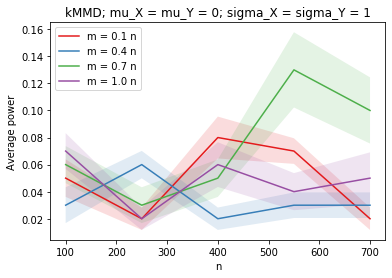

In [10]:
colors = sns.color_palette("Set1", n_colors = len(deltas))
fig, ax = plt.subplots(1,1)

for i, delta in enumerate(deltas):
    ax.plot(ns, mmd_power_means[:, i], label="m = %1.1f n"%(delta), c=colors[i])
    ax.fill_between(ns, 
            mmd_power_means[:,i] + 1.96*mmd_power_stderrs[:, i]/np.sqrt(mc_its), 
            mmd_power_means[:,i] - 1.96*mmd_power_stderrs[:, i]/np.sqrt(mc_its), 
            where=mmd_power_means[:, i] + 1.96*mmd_power_stderrs[:, i]/np.sqrt(mc_its) >= mmd_power_means[:, i] - 1.96*mmd_power_stderrs[:, i]/np.sqrt(mc_its), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('Average power')

ax.set_title('kMMD; mu_X = mu_Y = 0; sigma_X = sigma_Y = 1')
plt.savefig('kmmd_power_plots.pdf')